# SMYLE Terrestrial Water Storage (TWS) potential predictability

In [1]:
%load_ext autoreload
%autoreload 2
import xarray as xr 
import numpy as np  
import cftime
import copy
import scipy.stats
from scipy import signal
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xesmf as xe
%matplotlib inline

from SMYLEutils import calendar_utils as cal
from SMYLEutils import stat_utils as stat
from SMYLEutils import mapplot_utils as maps
from SMYLEutils import colorbar_utils as cbars
from SMYLEutils import io_utils as io
from SMYLEutils import regrid_utils as regrid

In [2]:
import dask
from dask.distributed import wait
dask.__version__

'2021.09.0'

## Data I/O using Dask

### Create Dask Cluster

In [100]:
cluster.close()
client.close()

distributed.core - ERROR - Exception while handling op register-client
Traceback (most recent call last):
  File "/glade/work/yeager/miniconda3/envs/smyle-analysis/lib/python3.8/site-packages/distributed/core.py", line 502, in handle_comm
    result = await result
  File "/glade/work/yeager/miniconda3/envs/smyle-analysis/lib/python3.8/site-packages/distributed/scheduler.py", line 5249, in add_client
    self.remove_client(client=client)
  File "/glade/work/yeager/miniconda3/envs/smyle-analysis/lib/python3.8/site-packages/distributed/scheduler.py", line 5276, in remove_client
    self.client_releases_keys(
  File "/glade/work/yeager/miniconda3/envs/smyle-analysis/lib/python3.8/site-packages/distributed/scheduler.py", line 5014, in client_releases_keys
    self.transitions(recommendations)
  File "/glade/work/yeager/miniconda3/envs/smyle-analysis/lib/python3.8/site-packages/distributed/scheduler.py", line 7119, in transitions
    self.send_all(client_msgs, worker_msgs)
  File "/glade/wor

In [4]:
def get_ClusterClient():
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    cluster = PBSCluster(
        cores=1,
        memory='20GB',
        processes=1,
        queue='casper',
        resource_spec='select=1:ncpus=1:mem=20GB',
        project='NCGD0011',
        walltime='02:00:00',
        interface='ib0',)

    dask.config.set({
        'distributed.dashboard.link':
        'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status',
        'array.slicing.split_large_chunks': True
    })
    client = Client(cluster)
    return cluster, client

cluster, client = get_ClusterClient()
cluster.scale(30) 

In [5]:
cluster

### Read in CLM monthly data; Convert to Seasonal averages (DJF, MAM, JJA, SON)
- Chosen field is returned as a dask array with leading dimensions of Y (initialization year), M (ensemble member), and L (lead season). For example, for November starts, L=1 corresponds to first DJF season.
- "time" which gives prediction verification time (centered time for a given season) is also dimensioned with (Y,L)

In [6]:
# This preprocessor will return a monthly mean field
def preprocessor(ds0,nlead,field):
    """ This preprocessor is applied on an individual timeseries file basis. Edit this appropriately
    for a your analysis to speed up processing. 
    """
    d0 = cal.time_set_midmonth(ds0,'time')
    d0 = d0.isel(time=slice(0, nlead))
    d0 = d0.assign_coords({"lon":ds0.lon, "lat":ds0.lat})
    d0 = d0.assign_coords(L=("time", np.arange(d0.sizes["time"])+1))
    d0 = d0.swap_dims({"time": "L"})
    d0 = d0.reset_coords(["time"])
    d0["time"] = d0.time.expand_dims("Y")
    d0 = d0[[field,'time']]
    d0 = d0.chunk({'L':-1})
    return d0

In [7]:
# SMYLE-NOV TWS data
field = 'TWS'
datadir = '/glade/campaign/cesm/development/espwg/SMYLE/archive/'
casename = 'b.e21.BSMYLE.f09_g17.????-MM.EEE'
filetype = '.clm2.h0.'
filetemplate = datadir+casename+'/lnd/proc/tseries/month_1/'+casename+filetype+field+'.*.nc'
ens = 20 
nlead = 24
firstyear = 1970
lastyear  = 2018
startmonth = 11
chunk = {}
smyle11 = io.get_monthly_data(filetemplate,filetype,ens,nlead,field,firstyear,lastyear,startmonth,preprocessor,chunks=chunk)
smyle11.nbytes/1e9 #GB

5.202259752

In [8]:
%%time
# convert monthly data to seasonal data
smyle11 = cal.mon_to_seas_dask(smyle11).persist()

CPU times: user 12.3 s, sys: 213 ms, total: 12.5 s
Wall time: 12.9 s


In [9]:
%%time
# SMYLE-FEB TWS data
startmonth = 2
smyle02 = io.get_monthly_data(filetemplate,filetype,ens,nlead,field,firstyear,lastyear,startmonth,preprocessor,chunks=chunk)
print('array size = '+str(smyle02.nbytes/1e9)+ ' GB') #GB

array size = 5.202259752 GB
CPU times: user 1min 2s, sys: 19.9 s, total: 1min 22s
Wall time: 1min 26s


In [10]:
%%time
# convert monthly data to seasonal data
smyle02 = cal.mon_to_seas_dask(smyle02).persist()

CPU times: user 13.8 s, sys: 157 ms, total: 13.9 s
Wall time: 14.4 s


In [11]:
%%time
# SMYLE-MAY TWS data
startmonth = 5
smyle05 = io.get_monthly_data(filetemplate,filetype,ens,nlead,field,firstyear,lastyear,startmonth,preprocessor,chunks=chunk)
print('data set = '+str(smyle05.nbytes/1e9)+ ' GB') #GB

data set = 5.202259752 GB
CPU times: user 1min 3s, sys: 19.9 s, total: 1min 23s
Wall time: 1min 29s


In [12]:
%%time
# convert monthly data to seasonal data
smyle05 = cal.mon_to_seas_dask(smyle05).persist()

CPU times: user 14.5 s, sys: 173 ms, total: 14.7 s
Wall time: 15.3 s


In [13]:
%%time
# SMYLE-AUG TWS data
startmonth = 8
smyle08 = io.get_monthly_data(filetemplate,filetype,ens,nlead,field,firstyear,lastyear,startmonth,preprocessor,chunks=chunk)
print('smyle08 data set = '+str(smyle08.nbytes/1e9)+ ' GB') #GB

smyle08 data set = 5.202259752 GB
CPU times: user 1min 6s, sys: 19.8 s, total: 1min 26s
Wall time: 1min 32s


In [14]:
%%time
# convert monthly data to seasonal data
smyle08 = cal.mon_to_seas_dask(smyle08).persist()

CPU times: user 14.4 s, sys: 157 ms, total: 14.6 s
Wall time: 15.1 s


### Regrid Hindcast data

In [15]:
## Define 2x2 destgrid
destgrid = xr.Dataset({'lat':np.arange(-90,92,2),'lon':np.arange(0,360,2)})
ny = destgrid.sizes['lat']
nx = destgrid.sizes['lon']
destgrid['mask'] = xr.DataArray(np.ones((ny,nx)),dims=["lat", "lon"],coords={"lat": destgrid.lat, "lon": destgrid.lon})
rEarth = 6378.1
destgrid['area'] = xr.DataArray(np.ones((ny,nx)),dims=["lat", "lon"],coords={"lat": destgrid.lat, "lon": destgrid.lon})*np.cos(np.deg2rad(destgrid.lat))*rEarth**2
destgrid['lat'] = destgrid['lat'].assign_attrs({'units':'degrees_north','long_name':'latitude'})
destgrid['lon'] = destgrid['lon'].assign_attrs({'units':'degrees_east','long_name':'longitude'})
destgrid = regrid.add_grid_bounds(destgrid)

In [16]:
smyle11 = regrid.add_grid_bounds(smyle11)
smyle02 = regrid.add_grid_bounds(smyle02)
smyle05 = regrid.add_grid_bounds(smyle05)
smyle08 = regrid.add_grid_bounds(smyle08)

In [17]:
## Create regridder from CAM-FV1deg to destgrid
regrid_cam1deg = xe.Regridder(smyle11, destgrid, 'conservative', periodic=True)

In [18]:
%%time
smyle11_da = regrid_cam1deg(smyle11.TWS,skipna=True, na_thres=0.2).load()
smyle11_time = smyle11.time.load()
smyle02_da = regrid_cam1deg(smyle02.TWS,skipna=True, na_thres=0.2).load()
smyle02_time = smyle02.time.load()
smyle05_da = regrid_cam1deg(smyle05.TWS,skipna=True, na_thres=0.2).load()
smyle05_time = smyle05.time.load()
smyle08_da = regrid_cam1deg(smyle08.TWS,skipna=True, na_thres=0.2).load()
smyle08_time = smyle08.time.load()

/glade/work/yeager/miniconda3/envs/smyle-analysis/lib/python3.8/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(
/glade/work/yeager/miniconda3/envs/smyle-analysis/lib/python3.8/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(
/glade/work/yeager/miniconda3/envs/smyle-analysis/lib/python3.8/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(
/glade/work/yeager/miniconda3/envs/smyle-analysis/lib/python3.8/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc

CPU times: user 1min 12s, sys: 50.9 s, total: 2min 3s
Wall time: 2min 10s


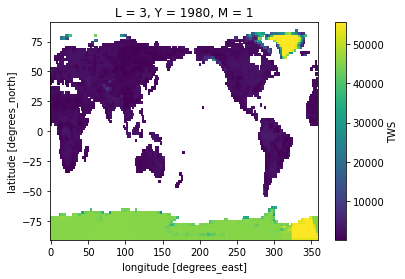

In [19]:
smyle11_da.isel(Y=10,L=0,M=0).plot();

### DataArrays are manageable size now (and in memory), so you could release Dask cluster 

In [21]:
## Save Fig data to file:
outdir = '/glade/scratch/yeager/SMYLE_paper/'

ds1 = smyle11_da.to_dataset()
ds1['time'] = smyle11_time
ds1.to_netcdf(outdir+'SMYLE11_TWS_seas_2x2.nc')

ds1 = smyle02_da.to_dataset()
ds1['time'] = smyle02_time
ds1.to_netcdf(outdir+'SMYLE02_TWS_seas_2x2.nc')

ds1 = smyle05_da.to_dataset()
ds1['time'] = smyle05_time
ds1.to_netcdf(outdir+'SMYLE05_TWS_seas_2x2.nc')

ds1 = smyle08_da.to_dataset()
ds1['time'] = smyle08_time
ds1.to_netcdf(outdir+'SMYLE08_TWS_seas_2x2.nc')

In [31]:
## Retrieve TWS-saved Fig data:
outdir = '/glade/scratch/yeager/SMYLE_paper/'
smyle11_seas = xr.open_dataset(outdir+'SMYLE11_TWS_seas_2x2.nc')
smyle11_da = smyle11_seas['TWS']
smyle02_seas = xr.open_dataset(outdir+'SMYLE02_TWS_seas_2x2.nc')
smyle02_da = smyle02_seas['TWS']
smyle05_seas = xr.open_dataset(outdir+'SMYLE05_TWS_seas_2x2.nc')
smyle05_da = smyle05_seas['TWS']
smyle08_seas = xr.open_dataset(outdir+'SMYLE08_TWS_seas_2x2.nc')
smyle08_da = smyle08_seas['TWS']

### Get results from CLM5 SMYLE-TRENDY to assess potential predictability

In [22]:
obs_dir = '/glade/campaign/cesm/development/espwg/SMYLE/initial_conditions/CLM5_SMYLE-Trendy/proc/tseries/month_1/'
fin = 'smyle_Transient.clm2.h0.'+field+'.185001-201812.nc'
#ds_clm = time_set_mid(xr.open_dataset(obs_dir+fin,decode_times=True),'time')
ds_clm = xr.open_dataset(obs_dir+fin,decode_times=False)
clm_montime_vals = [cftime.DatetimeNoLeap(1850+year, 1+month, 15) for year in range(169) for month in range(12)]
ds_clm['time'] = clm_montime_vals
ds_clm = ds_clm.sel(time=slice('1960','2018'))
ds_clm['time']

<xarray.DataArray 'time' (time: 708)>
array([cftime.DatetimeNoLeap(1960, 1, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1960, 2, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1960, 3, 15, 0, 0, 0, 0, has_year_zero=True), ...,
       cftime.DatetimeNoLeap(2018, 10, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2018, 11, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2018, 12, 15, 0, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 1960-01-15 00:00:00 ... 2018-12-15 00:00:00

In [96]:
ds_clm

<xarray.Dataset>
Dimensions:       (levgrnd: 25, levlak: 10, levdcmp: 25, lon: 288, lat: 192, time: 708, hist_interval: 2)
Coordinates:
  * levgrnd       (levgrnd) float32 0.01 0.04 0.09 0.16 ... 19.48 28.87 42.0
  * levlak        (levlak) float32 0.05 0.6 2.1 4.6 ... 18.6 25.6 34.33 44.78
  * levdcmp       (levdcmp) float32 0.01 0.04 0.09 0.16 ... 19.48 28.87 42.0
  * lon           (lon) float32 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * lat           (lat) float32 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * time          (time) object 1960-01-15 00:00:00 ... 2018-12-15 00:00:00
Dimensions without coordinates: hist_interval
Data variables: (12/22)
    area          (lat, lon) float32 ...
    landfrac      (lat, lon) float32 ...
    landmask      (lat, lon) float64 ...
    pftmask       (lat, lon) float64 ...
    nbedrock      (lat, lon) float64 ...
    ZSOI          (levgrnd, lat, lon) float32 ...
    ...            ...
    mscur         (time) float64 ...
    nstep         (time) float64 ...
    time_bounds   (time, hist_interval) float64 ...
    date_written  (time) object ...
    time_written  (time) object ...
    TWS           (time, lat, lon) float32 ...
Attributes: (12/100)
    title:                                     CLM History file information
    comment:                                   NOTE: None of the variables ar...
    Conventions:                               CF-1.0
    history:                                   created on 12/15/20 17:18:15
    source:                                    Community Land Model CLM4.0
    hostname:                                  cheyenne
    ...                                        ...
    cft_irrigated_switchgrass:                 60
    cft_tropical_corn:                         61
    cft_irrigated_tropical_corn:               62
    cft_tropical_soybean:                      63
    cft_irrigated_tropical_soybean:            64
    time_period_freq:                          month_1

### Compute OBS seasonal averages

In [23]:
def obs_convert_mon_to_seas(da,field):
    """ Given a monthly xarray DataArray, convert to 
    seasonal averages and introduce a separate season dimension."""
    season = xr.DataArray(['DJF','MAM','JJA','SON'],dims='season',name='season')
    da_group = cal.mon_to_seas(da).groupby('time.month')
    xrlist = []
    for i in [1,4,7,10]:
        tmp = da_group[i]
        tmp = tmp.assign_coords(year=("time", np.unique(tmp.time.dt.year.values)))
        tmp = tmp.swap_dims({"time": "year"}).to_dataset(name=field)
        tmp = tmp.reset_coords(["time"])
        tmp["time"] = tmp.time.expand_dims("season")
        xrlist.append(tmp)
    da_seas = xr.concat(xrlist,dim=season)
    return da_seas

In [24]:
clm_seas = obs_convert_mon_to_seas(ds_clm.TWS,'TWS')

In [25]:
## convert OBS to anomalies from 1972-2017
clm_seas = clm_seas - clm_seas.sel(year=slice(1972,2018)).mean('year')

In [26]:
clm_seas.year

<xarray.DataArray 'year' (year: 60)>
array([1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971,
       1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983,
       1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995,
       1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007,
       2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019])
Coordinates:
  * year     (year) int64 1960 1961 1962 1963 1964 ... 2015 2016 2017 2018 2019

In [27]:
# Get rid of spurious 2019 values
clm_seas = clm_seas.sel(year=slice(1960,2018))
clm_seas

<xarray.Dataset>
Dimensions:  (year: 59, lon: 288, lat: 192, season: 4)
Coordinates:
  * year     (year) int64 1960 1961 1962 1963 1964 ... 2014 2015 2016 2017 2018
  * lon      (lon) float32 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * lat      (lat) float32 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * season   (season) <U3 'DJF' 'MAM' 'JJA' 'SON'
Data variables:
    TWS      (season, year, lat, lon) float64 nan nan nan nan ... nan nan nan

### Regrid 

In [28]:
clm_seas = regrid.add_grid_bounds(clm_seas)

In [29]:
%%time
clm_recon = regrid_cam1deg(clm_seas.TWS,skipna=True, na_thres=0.2)

/glade/work/yeager/miniconda3/envs/smyle-analysis/lib/python3.8/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


CPU times: user 182 ms, sys: 70.4 ms, total: 253 ms
Wall time: 260 ms


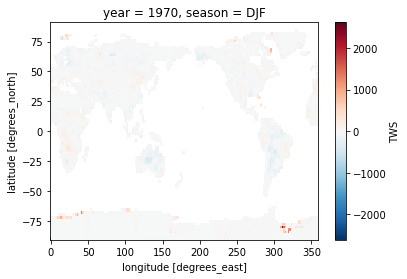

In [30]:
clm_recon.isel(year=10,season=0).plot()

# Anomaly Correlation Plots

In [31]:
# Compute de-drifted anomalies from 1972-2017 climatology
smyle11_anom,smyle11_clim = stat.remove_drift(smyle11_da,smyle11_time,1972,2018)
smyle02_anom,smyle02_clim = stat.remove_drift(smyle02_da,smyle02_time,1972,2018)
smyle05_anom,smyle05_clim = stat.remove_drift(smyle05_da,smyle05_time,1972,2018)
smyle08_anom,smyle08_clim = stat.remove_drift(smyle08_da,smyle08_time,1972,2018)

In [32]:
%%time
smyle11_skill = stat.leadtime_skill_seas(smyle11_anom,smyle11_time,clm_recon)
smyle02_skill = stat.leadtime_skill_seas(smyle02_anom,smyle02_time,clm_recon)
smyle05_skill = stat.leadtime_skill_seas(smyle05_anom,smyle05_time,clm_recon)
smyle08_skill = stat.leadtime_skill_seas(smyle08_anom,smyle08_time,clm_recon)

CPU times: user 8.28 s, sys: 1.62 s, total: 9.9 s
Wall time: 10.5 s


In [33]:
# Mask Antarctica
smyle11_skill = smyle11_skill.where(smyle11_skill.lat>-60.)
smyle02_skill = smyle02_skill.where(smyle02_skill.lat>-60.)
smyle05_skill = smyle05_skill.where(smyle05_skill.lat>-60.)
smyle08_skill = smyle08_skill.where(smyle08_skill.lat>-60.)

In [34]:
# Zero out ACC where insignificant
siglvl = 0.1
smyle11_skill['corr'] = smyle11_skill.corr.where(smyle11_skill.pval<siglvl)
smyle02_skill['corr'] = smyle02_skill.corr.where(smyle02_skill.pval<siglvl)
smyle05_skill['corr'] = smyle05_skill.corr.where(smyle05_skill.pval<siglvl)
smyle08_skill['corr'] = smyle08_skill.corr.where(smyle08_skill.pval<siglvl)

CPU times: user 974 ms, sys: 16.9 ms, total: 991 ms
Wall time: 1.06 s


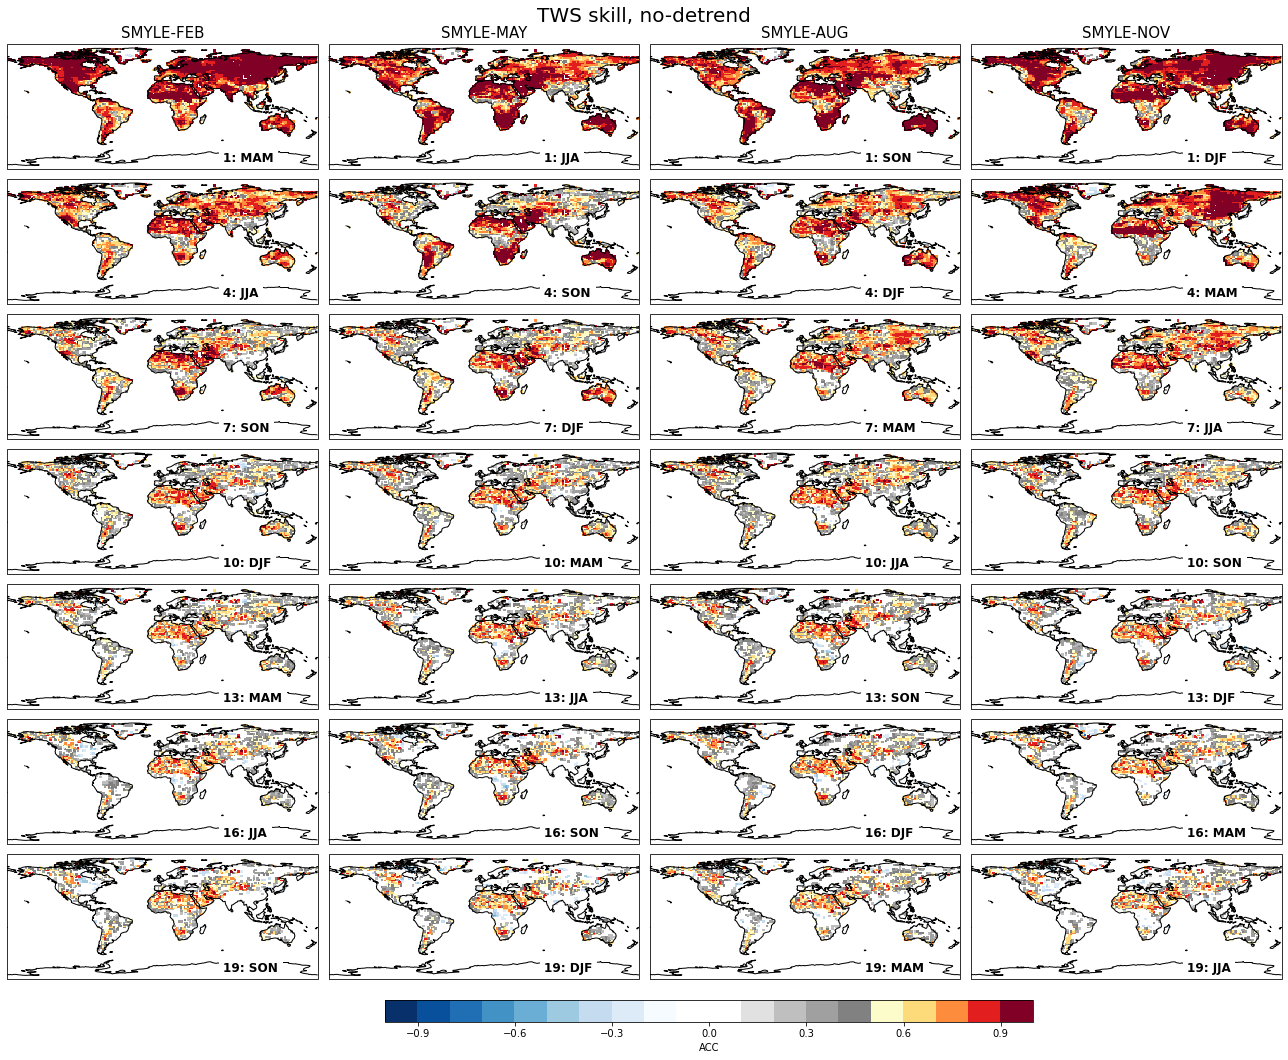

In [35]:
%%time
ci = 0.1
cmin = -1
cmax = 1
hatchlevs = [0,0.1,100]
fig = plt.figure(figsize=(18,15))
nrows=7
ncols=4

proj = ccrs.PlateCarree()
#proj = ccrs.Robinson(central_longitude=0)
colstr = ['SMYLE-FEB','SMYLE-MAY','SMYLE-AUG','SMYLE-NOV','DPLE-NOV']
ltime = ['1','4','7','10','13','16','19']
lstr = ''
rstr = ''
fsize=12
fweight='bold'
cmap = "blue2red_acc"
coff = 0.5
siglvl = 0.1
xloc = 70
yloc = -79

for i in range(nrows):
    if i>0:
        colstr=['','','','','']
    leadstr = ltime[i]+': '
    ax1,cntr1 = maps.map_pcolor_global_subplot(fig, smyle02_skill.corr.isel(L=i), smyle02_skill.lon, smyle02_skill.lat,
                                       ci,cmin,cmax,colstr[0],nrows,ncols,i*4+1,proj,cmap=cmap,cutoff=coff)
    ldstr = ltime[i] + ': ' + str(smyle02_skill.isel(L=i).season.values)
    ax1.text(xloc,yloc,ldstr,fontsize=fsize,fontweight=fweight,backgroundcolor='white')
    
    ax2,cntr2 = maps.map_pcolor_global_subplot(fig, smyle05_skill.corr.isel(L=i), smyle05_skill.lon, smyle05_skill.lat,
                                       ci,cmin,cmax,colstr[1],nrows,ncols,i*4+2,proj,cmap=cmap,cutoff=coff)
    ldstr = ltime[i] + ': ' + str(smyle05_skill.isel(L=i).season.values)
    ax2.text(xloc,yloc,ldstr,fontsize=fsize,fontweight=fweight,backgroundcolor='white')
    
    ax3,cntr3 = maps.map_pcolor_global_subplot(fig, smyle08_skill.corr.isel(L=i), smyle08_skill.lon, smyle08_skill.lat,
                                       ci,cmin,cmax,colstr[2],nrows,ncols,i*4+3,proj,cmap=cmap,cutoff=coff)
    ldstr = ltime[i] + ': ' + str(smyle08_skill.isel(L=i).season.values)
    ax3.text(xloc,yloc,ldstr,fontsize=fsize,fontweight=fweight,backgroundcolor='white')
    
    ax4,cntr4 = maps.map_pcolor_global_subplot(fig, smyle11_skill.corr.isel(L=i), smyle11_skill.lon, smyle11_skill.lat,
                                       ci,cmin,cmax,colstr[3],nrows,ncols,i*4+4,proj,cmap=cmap,cutoff=coff)
    ldstr = ltime[i] + ': ' + str(smyle11_skill.isel(L=i).season.values)
    ax4.text(xloc,yloc,ldstr,fontsize=fsize,fontweight=fweight,backgroundcolor='white')
    
fig.suptitle('TWS skill, no-detrend',fontsize=20)
fig.tight_layout()
fig.subplots_adjust(bottom=0.08)
cbar_ax = fig.add_axes([0.3, 0.04, 0.5, 0.02])
fig.colorbar(cntr1, cax=cbar_ax, label='ACC', orientation='horizontal')

### Use Linear Detrending

In [36]:
%%time
smyle11_skill = stat.leadtime_skill_seas(smyle11_anom,smyle11_time,clm_recon,detrend=True)
smyle02_skill = stat.leadtime_skill_seas(smyle02_anom,smyle02_time,clm_recon,detrend=True)
smyle05_skill = stat.leadtime_skill_seas(smyle05_anom,smyle05_time,clm_recon,detrend=True)
smyle08_skill = stat.leadtime_skill_seas(smyle08_anom,smyle08_time,clm_recon,detrend=True)

CPU times: user 1min 59s, sys: 8.17 s, total: 2min 7s
Wall time: 2min 12s


In [37]:
# Mask Antarctica
smyle11_skill = smyle11_skill.where(smyle11_skill.lat>-60.)
smyle02_skill = smyle02_skill.where(smyle02_skill.lat>-60.)
smyle05_skill = smyle05_skill.where(smyle05_skill.lat>-60.)
smyle08_skill = smyle08_skill.where(smyle08_skill.lat>-60.)

In [38]:
# Zero out ACC where insignificant
siglvl = 0.1
smyle11_skill['corr'] = smyle11_skill.corr.where(smyle11_skill.pval<siglvl)
smyle02_skill['corr'] = smyle02_skill.corr.where(smyle02_skill.pval<siglvl)
smyle05_skill['corr'] = smyle05_skill.corr.where(smyle05_skill.pval<siglvl)
smyle08_skill['corr'] = smyle08_skill.corr.where(smyle08_skill.pval<siglvl)

CPU times: user 966 ms, sys: 26.8 ms, total: 993 ms
Wall time: 1.03 s


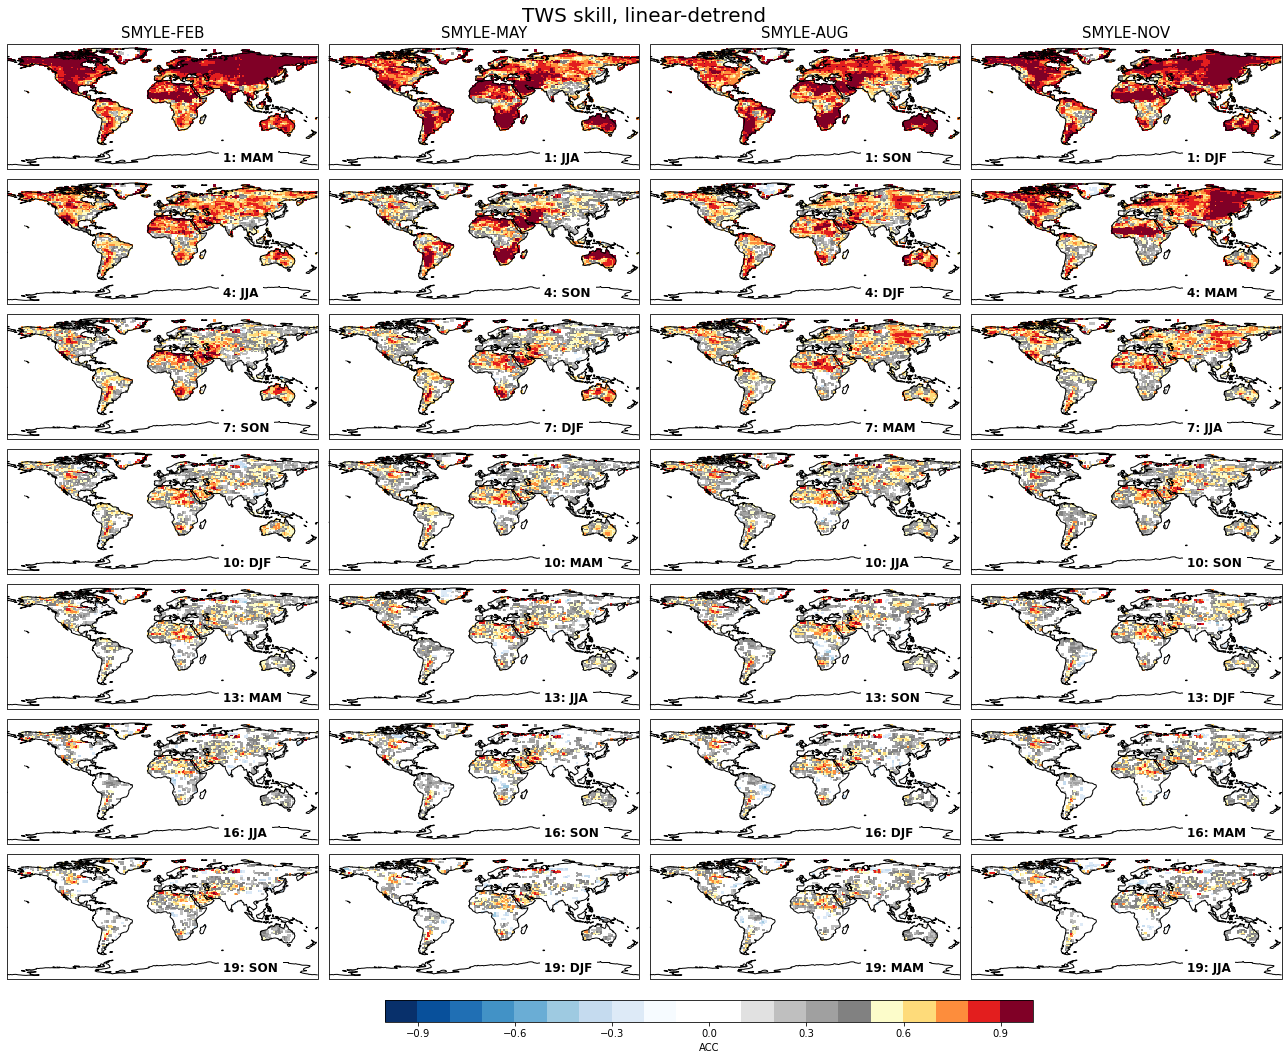

In [39]:
%%time
ci = 0.1
cmin = -1
cmax = 1
hatchlevs = [0,0.1,100]
fig = plt.figure(figsize=(18,15))
nrows=7
ncols=4

proj = ccrs.PlateCarree()
#proj = ccrs.Robinson(central_longitude=0)
colstr = ['SMYLE-FEB','SMYLE-MAY','SMYLE-AUG','SMYLE-NOV','DPLE-NOV']
ltime = ['1','4','7','10','13','16','19']
lstr = ''
rstr = ''
fsize=12
fweight='bold'
cmap = "blue2red_acc"
coff = 0.5
siglvl = 0.1
xloc = 70
yloc = -79

for i in range(nrows):
    if i>0:
        colstr=['','','','','']
    leadstr = ltime[i]+': '
    ax1,cntr1 = maps.map_pcolor_global_subplot(fig, smyle02_skill.corr.isel(L=i), smyle02_skill.lon, smyle02_skill.lat,
                                       ci,cmin,cmax,colstr[0],nrows,ncols,i*4+1,proj,cmap=cmap,cutoff=coff)
    ldstr = ltime[i] + ': ' + str(smyle02_skill.isel(L=i).season.values)
    ax1.text(xloc,yloc,ldstr,fontsize=fsize,fontweight=fweight,backgroundcolor='white')
    
    ax2,cntr2 = maps.map_pcolor_global_subplot(fig, smyle05_skill.corr.isel(L=i), smyle05_skill.lon, smyle05_skill.lat,
                                       ci,cmin,cmax,colstr[1],nrows,ncols,i*4+2,proj,cmap=cmap,cutoff=coff)
    ldstr = ltime[i] + ': ' + str(smyle05_skill.isel(L=i).season.values)
    ax2.text(xloc,yloc,ldstr,fontsize=fsize,fontweight=fweight,backgroundcolor='white')
    
    ax3,cntr3 = maps.map_pcolor_global_subplot(fig, smyle08_skill.corr.isel(L=i), smyle08_skill.lon, smyle08_skill.lat,
                                       ci,cmin,cmax,colstr[2],nrows,ncols,i*4+3,proj,cmap=cmap,cutoff=coff)
    ldstr = ltime[i] + ': ' + str(smyle08_skill.isel(L=i).season.values)
    ax3.text(xloc,yloc,ldstr,fontsize=fsize,fontweight=fweight,backgroundcolor='white')
    
    ax4,cntr4 = maps.map_pcolor_global_subplot(fig, smyle11_skill.corr.isel(L=i), smyle11_skill.lon, smyle11_skill.lat,
                                       ci,cmin,cmax,colstr[3],nrows,ncols,i*4+4,proj,cmap=cmap,cutoff=coff)
    ldstr = ltime[i] + ': ' + str(smyle11_skill.isel(L=i).season.values)
    ax4.text(xloc,yloc,ldstr,fontsize=fsize,fontweight=fweight,backgroundcolor='white')
    
fig.suptitle('TWS skill, linear-detrend',fontsize=20)
fig.tight_layout()
fig.subplots_adjust(bottom=0.08)
cbar_ax = fig.add_axes([0.3, 0.04, 0.5, 0.02])
fig.colorbar(cntr1, cax=cbar_ax, label='ACC', orientation='horizontal')

## Focus on high JJA skill over Southwest CONUS

CPU times: user 51.6 ms, sys: 951 µs, total: 52.5 ms
Wall time: 52.6 ms


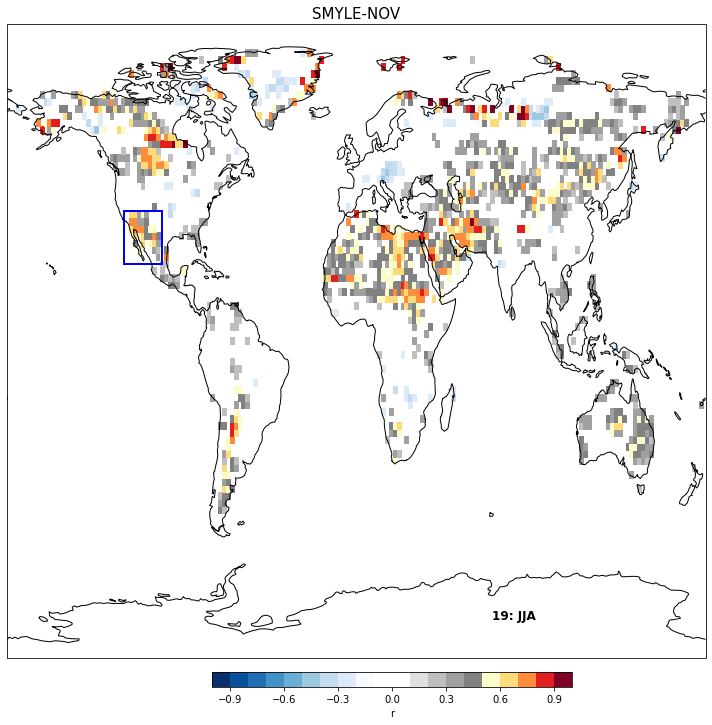

In [41]:
%%time
import matplotlib.patches as mpatches
ci = 0.1
cmin = -1.
cmax = 1.
hatchlevs = [0,0.1,100]
fig = plt.figure(figsize=(10,10))
nrows=7
ncols=4

proj = ccrs.PlateCarree()
#proj = ccrs.Robinson(central_longitude=0)
colstr = ['SMYLE-FEB','SMYLE-MAY','SMYLE-AUG','SMYLE-NOV']
ltime = ['1','4','7','10','13','16','19']
lstr = ''
rstr = ''
fsize=12
fweight='bold'

ax4,cntr4 = maps.map_pcolor_global_subplot(fig, smyle11_skill.corr.isel(L=6), smyle11_skill.lon, smyle11_skill.lat,
                                       ci,cmin,cmax,colstr[3],1,1,1,proj,cmap=cmap,cutoff=coff)
ldstr = ltime[6] + ': ' + str(smyle11_skill.isel(L=6).season.values)
ax4.text(xloc,yloc,ldstr,fontsize=fsize,fontweight=fweight,backgroundcolor='white')

ax4.add_patch(mpatches.Rectangle(xy=[-120, 22], width=20, height=15,facecolor='None',edgecolor='blue',lw=2,
                                    alpha=1.,
                                    transform=proj))

fig.tight_layout()
fig.subplots_adjust(bottom=0.08)
cbar_ax = fig.add_axes([0.3, 0.04, 0.5, 0.02])
fig.colorbar(cntr4, cax=cbar_ax, label='r', orientation='horizontal')

In [61]:
# SW regional-average
region1lonlat = [-120.,-100.,22.,37.]  
region1title = 'SW'

tmp = clm_seas['TWS'].sel(lat=slice(region1lonlat[2],region1lonlat[3])).sel(lon=slice(360+region1lonlat[0],360+region1lonlat[1]))
wgts = np.cos(np.deg2rad(tmp.lat))
trendy_tws = tmp.weighted(wgts).mean(("lon", "lat"))
trendy_raw_tws = ds_clm['TWS'].sel(lat=slice(region1lonlat[2],region1lonlat[3])).sel(lon=slice(360+region1lonlat[0],360+region1lonlat[1])).weighted(wgts).mean(("lon", "lat"))

tmp = smyle11_anom.isel(L=6).mean('M').sel(lat=slice(region1lonlat[2],region1lonlat[3])).sel(lon=slice(360+region1lonlat[0],360+region1lonlat[1]))
wgts = np.cos(np.deg2rad(tmp.lat))
smyle_tws = tmp.weighted(wgts).mean(("lon", "lat")).rename({'Y':'time'})
smyle_tws['time'] = smyle11.isel(L=6).time.dt.year.values

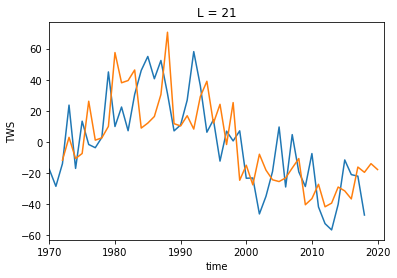

In [62]:
trendy_tws.sel(season='JJA').plot(xlim=[1970,2021]);
smyle_tws.plot()

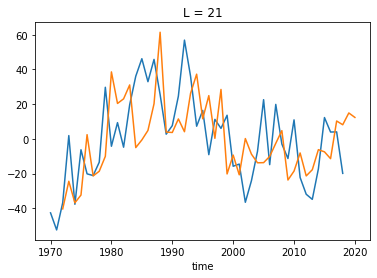

In [63]:
stat.detrend_linear(trendy_tws.sel(season='JJA').sel(year=slice(1970,2021)),'year').plot();
stat.detrend_linear(smyle_tws.sel(time=slice(1970,2021)),'time').plot();

In [64]:
a = stat.detrend_linear(trendy_tws.sel(season='JJA').rename({'year':'time'}),'time')
b = stat.detrend_linear(smyle_tws,'time')
a,b = xr.align(a,b)
xr.corr(a,b)

<xarray.DataArray ()>
array(0.39246782)
Coordinates:
    season   <U3 'JJA'
    L        int64 21

In [65]:
a

<xarray.DataArray (time: 47)>
array([-14.33694921,  23.55532245, -16.79572587,  13.8317814 ,
        -0.82994612,  -2.58612717,   4.31950151,  46.69433264,
        11.9422353 ,  24.75838259,   9.83444129,  33.48307501,
        49.16609879,  58.45892436,  44.44712779,  56.48869068,
        35.45806397,  11.86485819,  15.99924181,  32.20291101,
        63.69633899,  42.13060001,  12.53654367,  20.8484249 ,
        -5.40483379,  14.13747604,   8.16421128,  14.94459493,
       -15.20543519, -14.74140654, -37.52559137, -25.90909627,
        -9.70330056,  19.23355057, -18.98380647,  14.94331436,
        -8.65901313, -17.77868481,   3.69559376, -30.28351907,
       -40.71225414, -44.44015549, -27.66286888,   1.1195194 ,
        -7.99843158,  -8.69983481, -33.36896552])
Coordinates:
  * time     (time) int64 1972 1973 1974 1975 1976 ... 2014 2015 2016 2017 2018
    season   <U3 'JJA'

In [66]:
%%time
smyle11_reg = smyle11_anom.sel(lat=slice(region1lonlat[2],region1lonlat[3])).sel(lon=slice(360+region1lonlat[0],360+region1lonlat[1]))
smyle11_reg = smyle11_reg.weighted(wgts).mean(("lon", "lat"))
smyle02_reg = smyle02_anom.sel(lat=slice(region1lonlat[2],region1lonlat[3])).sel(lon=slice(360+region1lonlat[0],360+region1lonlat[1]))
smyle02_reg = smyle02_reg.weighted(wgts).mean(("lon", "lat"))
smyle05_reg = smyle05_anom.sel(lat=slice(region1lonlat[2],region1lonlat[3])).sel(lon=slice(360+region1lonlat[0],360+region1lonlat[1]))
smyle05_reg = smyle05_reg.weighted(wgts).mean(("lon", "lat"))
smyle08_reg = smyle08_anom.sel(lat=slice(region1lonlat[2],region1lonlat[3])).sel(lon=slice(360+region1lonlat[0],360+region1lonlat[1]))
smyle08_reg = smyle08_reg.weighted(wgts).mean(("lon", "lat"))

CPU times: user 70.7 ms, sys: 0 ns, total: 70.7 ms
Wall time: 70.7 ms


In [67]:
%%time
smyle11_skill_reg = stat.leadtime_skill_seas(smyle11_reg,smyle11_time,trendy_tws,detrend=True)
smyle02_skill_reg = stat.leadtime_skill_seas(smyle02_reg,smyle02_time,trendy_tws,detrend=True)
smyle05_skill_reg = stat.leadtime_skill_seas(smyle05_reg,smyle05_time,trendy_tws,detrend=True)
smyle08_skill_reg = stat.leadtime_skill_seas(smyle08_reg,smyle08_time,trendy_tws,detrend=True)

CPU times: user 599 ms, sys: 662 µs, total: 600 ms
Wall time: 600 ms


### Create Persistence scores from autocorrelation of smoothed Trendy data

##### Method 1:  Compute autocorrelations of 3-month running mean monthly data with lead month lags matching SMYLE hindcasts

In [68]:
trendy_raw_tws.sel(time=slice("1970","2019")).time

<xarray.DataArray 'time' (time: 588)>
array([cftime.DatetimeNoLeap(1970, 1, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1970, 2, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1970, 3, 15, 0, 0, 0, 0, has_year_zero=True), ...,
       cftime.DatetimeNoLeap(2018, 10, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2018, 11, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2018, 12, 15, 0, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 1970-01-15 00:00:00 ... 2018-12-15 00:00:00

In [71]:
import xskillscore as xs
trendy_3mrunmean = trendy_raw_tws.rolling(time=3, center=True).mean().sel(time=slice("1970","2019"))
#trendy_3mrunmean.plot()
trendy_3mrunmean_dt = stat.detrend_linear(trendy_3mrunmean, 'time')

nl = 7
tshift = [3,6,9,12,15,18,21]
clist = []
for i in range(nl):
    tmp = trendy_3mrunmean_dt.shift(time=tshift[i])
    corr = xs.pearson_r(trendy_3mrunmean_dt,tmp,'time',skipna=True)
    clist.append(corr)
pers_skill = xr.concat(clist,dim=smyle11_skill.isel(L=slice(0,7)).L)

In [82]:
tmp = smyle11_skill.corr.isel(L=6).sel(lat=slice(-60,90))
tmp

<xarray.DataArray 'corr' (lat: 76, lon: 180)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
    L        int64 19
  * lon      (lon) int64 0 2 4 6 8 10 12 14 ... 344 346 348 350 352 354 356 358
  * lat      (lat) int64 -60 -58 -56 -54 -52 -50 -48 ... 78 80 82 84 86 88 90
    season   <U3 'JJA'

CPU times: user 489 ms, sys: 83.9 ms, total: 573 ms
Wall time: 591 ms


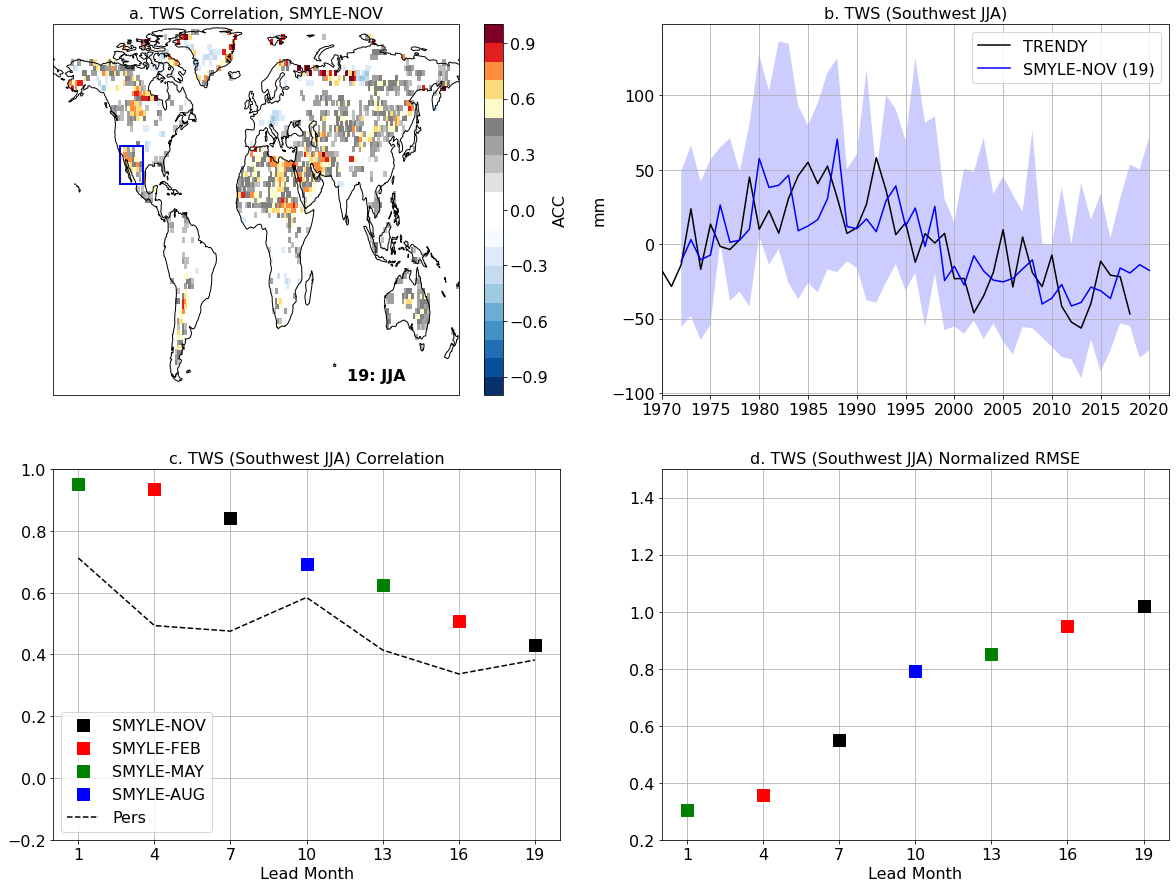

In [99]:
%%time
import matplotlib.patches as mpatches
ci = 0.1
cmin = -1
cmax = 1
hatchlevs = [0,0.1,100]
fig = plt.figure(figsize=(20,15))
nrow=2
ncol=2
plt.rcParams.update({'font.size': 16})

proj = ccrs.PlateCarree()
#proj = ccrs.Robinson(central_longitude=0)
colstr = ['SMYLE-FEB','SMYLE-MAY','SMYLE-AUG','SMYLE-NOV']
ltime = ['1','4','7','10','13','16','19']
lstr = ''
rstr = ''
fsize=16
fweight='bold'
xloc = 80
yloc = -55

tmp = smyle11_skill.corr.isel(L=6).sel(lat=slice(-60,85))
ax1,cntr1 = maps.map_pcolor_global_subplot(fig, tmp, tmp.lon, tmp.lat,
                                       ci,cmin,cmax,colstr[3],nrow,ncol,1,proj,cmap=cmap,cutoff=coff)
ldstr = ltime[6] + ': ' + str(smyle11_skill.isel(L=6).season.values)
ax1.text(xloc,yloc,ldstr,fontsize=fsize,fontweight=fweight,backgroundcolor='white')
ax1.add_patch(mpatches.Rectangle(xy=[-120, 22], width=20, height=15,facecolor='None',edgecolor='blue',lw=2,
                                    alpha=1.,
                                    transform=proj))
ax1.set_title('a. TWS Correlation, SMYLE-NOV',loc='center',fontsize=fsize)
fig.colorbar(cntr1, ax=ax1, label='ACC')

ax2 = fig.add_subplot(nrow,ncol,2)
ax2.plot(trendy_tws.year,trendy_tws.sel(season='JJA'),color='k',label='TRENDY')
smyle11_time = smyle11.isel(L=6).time.dt.year.values
ax2.plot(smyle11_time,smyle11_reg.mean('M').isel(L=6),color='b',label='SMYLE-NOV (19)')
ymin = smyle11_reg.min('M').isel(L=6)
ymax = smyle11_reg.max('M').isel(L=6)
ax2.fill_between(smyle11_time,ymin,ymax,fc='b',alpha=0.2)
ax2.legend(loc='upper right')
ax2.set_xticks(np.arange(1970,2025,5))
ax2.grid(True)
ax2.set_xlim([1970,2022])
ax2.set_title('b. TWS (Southwest JJA)',loc='center',fontsize=fsize)
#ax2.set_xlabel('Year')
ax2.set_ylabel('mm')
#ax2.set_ylim([-0.2,1])

ax3 = fig.add_subplot(nrow,ncol,3)
leadmon = smyle11_skill_reg.L
seasons = ['DJF','MAM','JJA','SON']
markers = ['D','o','s','P']
#ax3.set_ylabel('Correlation', fontsize=14)
ax3.set_title('c. TWS (Southwest JJA) Correlation',loc='center',fontsize=fsize)
ax3.plot(leadmon,smyle11_skill_reg.corr.where(smyle11_skill_reg.season=='JJA'),color='k',marker='s',fillstyle='none',linestyle='none')
ax3.plot(leadmon,smyle11_skill_reg.corr.where(smyle11_skill_reg.season=='JJA').where(smyle11_skill_reg.pval<0.1),color='k',marker='s',ms=12,label='SMYLE-NOV',linestyle='none')
ax3.plot(leadmon,smyle02_skill_reg.corr.where(smyle02_skill_reg.season=='JJA'),color='r',marker='s',fillstyle='none',linestyle='none')
ax3.plot(leadmon,smyle02_skill_reg.corr.where(smyle02_skill_reg.season=='JJA').where(smyle02_skill_reg.pval<0.1),color='r',marker='s',ms=12,label='SMYLE-FEB',linestyle='none')
ax3.plot(leadmon,smyle05_skill_reg.corr.where(smyle05_skill_reg.season=='JJA'),color='g',marker='s',fillstyle='none',linestyle='none')
ax3.plot(leadmon,smyle05_skill_reg.corr.where(smyle05_skill_reg.season=='JJA').where(smyle05_skill_reg.pval<0.1),color='g',marker='s',ms=12,label='SMYLE-MAY',linestyle='none')
ax3.plot(leadmon,smyle08_skill_reg.corr.where(smyle08_skill_reg.season=='JJA'),color='b',marker='s',fillstyle='none',linestyle='none')
ax3.plot(leadmon,smyle08_skill_reg.corr.where(smyle08_skill_reg.season=='JJA').where(smyle08_skill_reg.pval<0.1),color='b',marker='s',ms=12,label='SMYLE-AUG',linestyle='none')
ax3.plot(leadmon[0:7],pers_skill,color='k',linestyle='dashed',label='Pers')
#ax3.plot([1,10],[trendy_jja_ac1,trendy_jja_ac1],color='k',linestyle='dashed',label='Pers')
#ax3.plot([13,19],[trendy_jja_ac2,trendy_jja_ac2],color='k',linestyle='dashed')
ax3.legend(loc='lower left',ncol=1)
ax3.set_xticks(leadmon)
ax3.grid(True)
ax3.set_xlim([0,20])
ax3.set_ylim([-0.2,1])
ax3.set_xlabel('Lead Month')

ax4 = fig.add_subplot(nrow,ncol,4)
ax4.set_ylabel(r'', fontsize=14)
ax4.set_title('d. TWS (Southwest JJA) Normalized RMSE',loc='center',fontsize=fsize)
ax4.plot(leadmon,smyle11_skill_reg.nrmse.where(smyle11_skill_reg.season=='JJA'),color='k',marker='s',ms=12,linestyle='none')
ax4.plot(leadmon,smyle02_skill_reg.nrmse.where(smyle02_skill_reg.season=='JJA'),color='r',marker='s',ms=12,linestyle='none')
ax4.plot(leadmon,smyle05_skill_reg.nrmse.where(smyle05_skill_reg.season=='JJA'),color='g',marker='s',ms=12,linestyle='none')
ax4.plot(leadmon,smyle08_skill_reg.nrmse.where(smyle08_skill_reg.season=='JJA'),color='b',marker='s',ms=12,linestyle='none')
ax4.set_xticks(leadmon)
ax4.grid(True)
ax4.set_xlim([0,20])
ax4.set_ylim([0.2,1.5])
ax4.set_xlabel('Lead Month')

plt.savefig('Fig10_TWS_Southwest_JJA.png')